# Dlib CNN face detector

# Установка библиотек (после установки перезапустить среду)

In [1]:
! pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3 MB 55 kB/s 
     |████████████████████████████████| 3.8 MB 73.5 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
     |████████████████████████████████| 449 kB 68.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=b9e6f2527c121b82f05bed71db14cea605cb41f1883d8e3f6176db674907e2f0
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Success

In [2]:
!pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 29.5 MB/s 
     |████████████████████████████████| 15.7 MB 56.6 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
tensorflow-probability 0.15.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which

In [3]:
pip install gast==0.2.2

# Импорт библиотек

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import gdown

import dlib
from glob import glob
import os
import pickle

from sklearn.model_selection import train_test_split

In [2]:
tf.__version__

'2.0.0'

# Загрузка подготовленных данных

In [4]:
#models
!gdown https://drive.google.com/uc?id=1ZVE8gnLIGZuwnjEL8zHZaWBki3-KHrTO
!unzip -q VGGFace_data.zip

#lwf images
!gdown https://drive.google.com/uc?id=14-HN9wyGIyHl3b3zFw0PIUCalq6FrPWe
!unzip -q lfw.zip



#lfw crop images
#!gdown https://drive.google.com/uc?id=1TamFrm5BIFVVVtSwxQr3_T1BuF_TVA41
#!unzip -q lfwcrop.zip 

Downloading...
From: https://drive.google.com/uc?id=1ZVE8gnLIGZuwnjEL8zHZaWBki3-KHrTO
To: /content/VGGFace_data.zip
100% 550M/550M [00:04<00:00, 132MB/s]
replace mmod_human_face_detector.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace classifier/keras_metadata.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Downloading...
From: https://drive.google.com/uc?id=14-HN9wyGIyHl3b3zFw0PIUCalq6FrPWe
To: /content/lfw.zip
100% 22.3M/22.3M [00:00<00:00, 43.3MB/s]


In [ ]:
# %cd data
# with open('person_all.pickle', 'rb') as f:
#   person_all = pickle.load(f)
# train_data = np.load('train_data.npy')
# train_labels = np.load('train_labels.npy')
# test_data = np.load('test_data.npy')
# test_labels = np.load('test_labels.npy')
# data_all = np.load('data_all.npy')
# labels_all = np.load('labels_all.npy')

# data_all_13_person = np.load('data_all_13_person.npy')
# labels_all_13_person = np.load('labels_all_13_person.npy')
# with open('person_13_dict.pickle', 'rb') as f:
#   person_13_dict = pickle.load(f)

/content/data


# Подготовка данных


## детекция лиц

In [5]:
# загружаем детектор
dnnFaceDetector=dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

In [34]:
# # создаем папки для изображений с детектированными лицами
os.mkdir('/content/lfwcrop/')
for person in glob('/content/lfw/*'):
  os.mkdir('/content/lfwcrop/'+person.split('/')[-1]+'/')

In [35]:
# Detect face, crop detected face and save them in corresponding person folder
path='/content/lfwcrop/'
for file_name in glob('/content/lfw/*/*.jpg'):
  try:
    img=cv2.imread(file_name)
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects=dnnFaceDetector(gray,1)
    left,top,right,bottom=0,0,0,0
    for (i,rect) in enumerate(rects):
      left=rect.rect.left() #x1
      top=rect.rect.top() #y1
      right=rect.rect.right() #x2
      bottom=rect.rect.bottom() #y2
    width=right-left
    height=bottom-top
    img_path=path+file_name.split('/')[-2]+'/'+file_name.split('/')[-1]
    img_crop=img[top:top+height,left:left+width]
    if img_crop.shape[0] != 0 and img_crop.shape[1] != 0:
      cv2.imwrite(img_path,img_crop)
  except ValueError:  
    pass

## подготовка векторных представлений

In [36]:
#определяем архитектуру модели
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [37]:
# загружаем веса модели
model.load_weights('vgg_face_weights.h5')

In [39]:
# заменяем выход модели на предпоследний слой и на выходе получаем вектор из 2622 значений
vgg_face=Model(inputs=model.layers[0].input,outputs=model.layers[-2].output)

In [40]:
#Prepare Training Data
data=[]
labels=[]
names=[]
person_folders=os.listdir('/content/lfwcrop')
person_rep = {}
for i,person in enumerate(person_folders):
    person_rep[i]=person
    image_names=os.listdir('/content/lfwcrop/'+person+'/')
    for image_name in image_names:
      img=load_img('/content/lfwcrop/'+person+'/'+image_name,target_size=(224,224))
      img=img_to_array(img)
      img=np.expand_dims(img,axis=0)
      img=preprocess_input(img)
      img_encode=vgg_face(img)
      data.append(np.squeeze(K.eval(img_encode)).tolist())
      labels.append(i)
data=np.array(data)
labels=np.array(labels)

In [44]:
data.shape

(1557, 2622)

In [45]:
labels.shape

(1557,)

In [47]:
person_rep

{0: 'Junichiro_Koizumi',
 1: 'Jacques_Chirac',
 2: 'Tony_Blair',
 3: 'Serena_Williams',
 4: 'Hugo_Chavez',
 5: 'Jean_Chretien',
 6: 'Donald_Rumsfeld',
 7: 'John_Ashcroft',
 8: 'Colin_Powell',
 9: 'George_W_Bush',
 10: 'Vladimir_Putin',
 11: 'Ariel_Sharon',
 12: 'Gerhard_Schroeder'}

# создание и обучение классификатора на отобранных данных

In [46]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

In [77]:
# Softmax regressor to classify images based on encoding 
classifier_model=Sequential()
classifier_model.add(Dense(units=100,input_dim=X_train.shape[1],kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.3))
classifier_model.add(Dense(units=10,kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.2))
classifier_model.add(Dense(units=len(person_rep),kernel_initializer='he_uniform'))
classifier_model.add(Activation('softmax'))
classifier_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='nadam',metrics=['accuracy'])

In [78]:
history = classifier_model.fit(X_train,y_train,epochs=60, validation_split=0.1)

Train on 1120 samples, validate on 125 samples
Epoch 1/60
1120/1120 [==============================] - 2s 1ms/sample - loss: 1.4486 - accuracy: 0.6295 - val_loss: 1.1136 - val_accuracy: 0.7280
Epoch 2/60
1120/1120 [==============================] - 0s 202us/sample - loss: 1.0173 - accuracy: 0.8196 - val_loss: 0.8557 - val_accuracy: 0.8400
Epoch 3/60
1120/1120 [==============================] - 0s 187us/sample - loss: 0.8902 - accuracy: 0.8616 - val_loss: 0.8715 - val_accuracy: 0.8800
Epoch 4/60
1120/1120 [==============================] - 0s 197us/sample - loss: 0.7908 - accuracy: 0.8911 - val_loss: 0.7150 - val_accuracy: 0.8960
Epoch 5/60
1120/1120 [==============================] - 0s 195us/sample - loss: 0.7070 - accuracy: 0.9089 - val_loss: 0.7243 - val_accuracy: 0.8560
Epoch 6/60
1120/1120 [==============================] - 0s 189us/sample - loss: 0.6438 - accuracy: 0.9098 - val_loss: 0.7086 - val_accuracy: 0.9040
Epoch 7/60
1120/1120 [==============================] - 0s 198us/sa

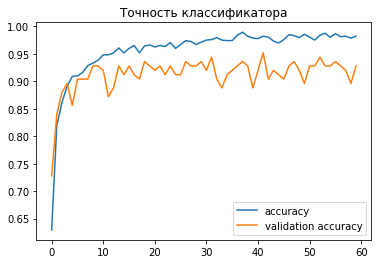

In [79]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность классификатора')
plt.legend(['accuracy','validation accuracy']);

In [80]:
classifier_model.evaluate(X_test,y_test)

312/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.34708351603685283, 0.9166667]

# предсказание

In [81]:
dnnFaceDetector=dlib.cnn_face_detection_model_v1('/content/mmod_human_face_detector.dat')

In [82]:
def detect_crop(img_path):
    try:
      img=cv2.imread(img_path)
      gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      rects=dnnFaceDetector(gray,1)
      left,top,right,bottom=0,0,0,0
      for (i,rect) in enumerate(rects):
        left=rect.rect.left() #x1
        top=rect.rect.top() #y1
        right=rect.rect.right() #x2
        bottom=rect.rect.bottom() #y2
      width=right-left
      height=bottom-top
      img_crop=img[top:top+height,left:left+width]      
    except ValueError:  
      pass
    plt.imshow(img[:,:,[2,1,0]])
    plt.imshow(img_crop[:,:,[2,1,0]])
    return img_crop

In [83]:
def vggmodel(path_to_weights):
  model = Sequential()
  model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(Convolution2D(4096, (7, 7), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(4096, (1, 1), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(2622, (1, 1)))
  model.add(Flatten())
  model.add(Activation('softmax'))

  model.load_weights(path_to_weights)
  
  # Remove Last Softmax layer and get model upto last flatten layer with outputs 2622 units
  vgg_face=Model(inputs=model.layers[0].input,outputs=model.layers[-2].output)

  return vgg_face

In [84]:
def get_embedding(img_crop):
  #img=load_img(img_crop,target_size=(224,224))
  img = cv2.resize(img_crop, dsize=(224,224))
  img=img_to_array(img)
  img=np.expand_dims(img,axis=0)
  img=preprocess_input(img)
  img_encode=vgg_face(img)
  return np.squeeze(K.eval(img_encode)).reshape(1,-1)

In [85]:
vgg_face = vggmodel('/content/vgg_face_weights.h5')
vgg_face.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_65_input (Inp [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_65 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_66 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_67 (ZeroPaddi (None, 114, 114, 64)      0   

In [86]:
!wget -O putin1.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/6/6f/RIAN_archive_100306_Vladimir_Putin%2C_Federal_Security_Service_Director.jpg/220px-RIAN_archive_100306_Vladimir_Putin%2C_Federal_Security_Service_Director.jpg 

--2022-01-14 13:22:32--  https://upload.wikimedia.org/wikipedia/commons/thumb/6/6f/RIAN_archive_100306_Vladimir_Putin%2C_Federal_Security_Service_Director.jpg/220px-RIAN_archive_100306_Vladimir_Putin%2C_Federal_Security_Service_Director.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20873 (20K) [image/jpeg]
Saving to: ‘putin1.jpg’

putin1.jpg          100%[===================>]  20.38K  --.-KB/s    in 0.001s  

2022-01-14 13:22:32 (22.3 MB/s) - ‘putin1.jpg’ saved [20873/20873]



In [87]:
!wget -O putin2.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT8z9V6cPmhzkl1pCp546wnK6XCOx71uCAJ3A&usqp=CAU 

--2022-01-14 13:22:33--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT8z9V6cPmhzkl1pCp546wnK6XCOx71uCAJ3A
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 142.250.81.206, 2607:f8b0:4004:82f::200e
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|142.250.81.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5464 (5.3K) [image/jpeg]
Saving to: ‘putin2.jpg’

putin2.jpg          100%[===================>]   5.34K  --.-KB/s    in 0s      

2022-01-14 13:22:33 (73.8 MB/s) - ‘putin2.jpg’ saved [5464/5464]



In [88]:
def prediction(img_path):
  face_crop = detect_crop(img_path)
  vec = get_embedding(face_crop)
  return person_rep[np.argmax(classifier_model.predict(vec))]

'Vladimir_Putin'

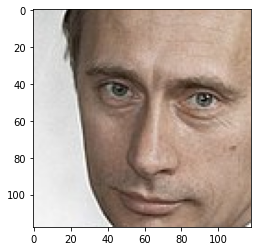

In [89]:
prediction('putin1.jpg')